In [1]:
import os 
import numpy as np
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
folder_dataset = "dataset/data pasien/" 

filenames = []
for folder in os.listdir(folder_dataset):
    files = os.listdir(folder_dataset + folder)
    files = [file for file in files if file.find(".csv") > -1]
    filenames.extend(files)

filenames

['AF 1.csv',
 'AF 2.csv',
 'AF 3.csv',
 'AF 4.csv',
 'AF 5.csv',
 'AF 6.csv',
 'AF 7.csv',
 'Normal 1.csv',
 'Normal 2.csv',
 'Normal 3.csv',
 'Normal 4.csv']

In [3]:
filename = filenames[7]

filename

'Normal 1.csv'

In [4]:
# read dataset, skip first row
ECG = pd.read_csv(os.path.join(folder_dataset, filename.replace(".csv", "") ,filename), skiprows = [0], sep=";")

ECG.columns = ['Time', 'ECG1', 'ECG2']

ECG.head()

,Time,ECG1,ECG2
0,18:40:18.063,-412.0,-789.0
1,18:40:18.103,-415.0,-783.0
2,18:40:18.143,-408.0,-802.0
3,18:40:18.183,-380.0,-733.0
4,18:40:18.223,-398.0,-736.0


In [5]:
# create Series with dtype Time
ECG["Idx_Time"] = pd.to_datetime(ECG["Time"]) #, errors='coerce', format="%H:%M:%S.%f")

#Set Time as Index
ECG.index = ECG["Idx_Time"]

# delete unused column 
ECG.drop('Idx_Time', axis=1, inplace=True)

ECG.drop('Time', axis=1, inplace=True)

In [6]:
# set sampling rate
fs = 25 #Hz

In [7]:
def plot_signal(data, fs, label="ECG sample raw data", y_label="Amplitude"):
    plt.figure(figsize=(20, 10))
    
    try :
        data = data.values
    except :
        data = np.array(data)
    
    # Calculate time values in seconds
    times = np.arange(data.shape[0], dtype='float') / fs

    plt.subplot(2, 1, 1)
    plt.plot(times, data[:, 0], '#1f77b4')
    plt.ylabel(y_label)
    plt.xlabel("Time (s)")
    plt.title(label + " - Channel 1")
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(times, data[:, 1], '#ff7f0e')
    plt.ylabel(y_label)
    plt.xlabel("Time (s)")
    plt.title(label + " - Channel 2")
    plt.grid(True)
    
    plt.show()

In [8]:
ECG.tail()

,ECG1,ECG2
Idx_Time,,
2021-08-24 18:47:32.678,584.0,1173.0
2021-08-24 18:47:32.718,1015.0,1989.0
2021-08-24 18:47:32.758,652.0,1729.0
2021-08-24 18:47:32.798,104.0,661.0
2021-08-24 18:47:32.838,-248.0,1.0


In [9]:
str(ECG.index.min().time()), str(ECG.index.max().time())

('18:40:16.219000', '18:47:32.838000')

18:40:18.063000 18:40:24.063000


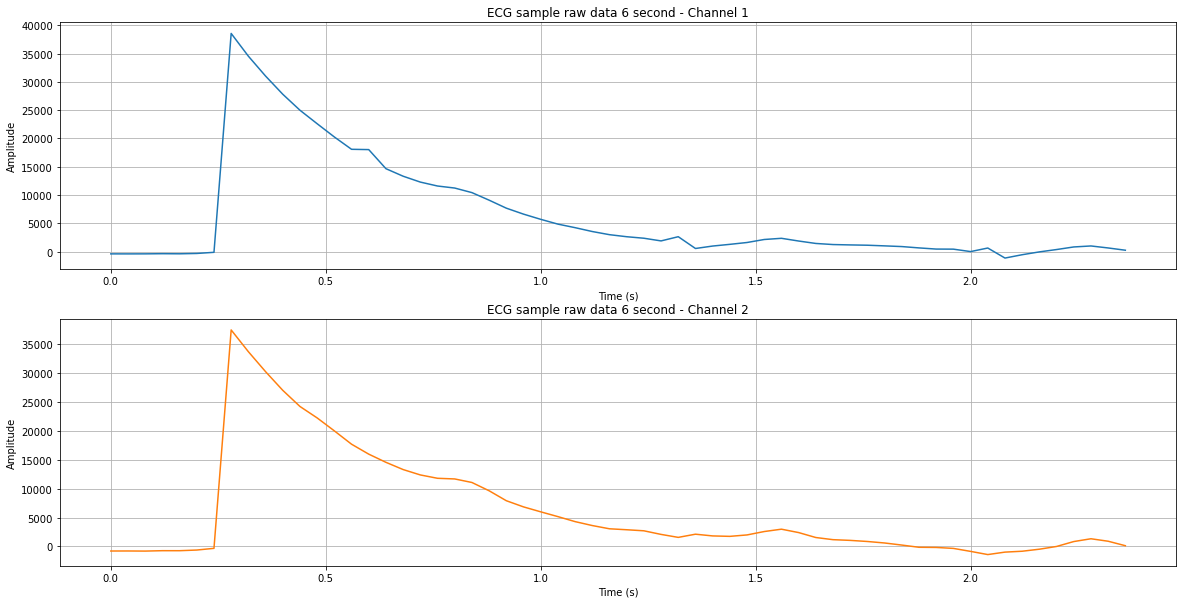

In [10]:
start = ECG.index[0].time()
end = (ECG.index[0] + datetime.timedelta(seconds=6)).time()
print(start, end)

plot_signal(ECG.between_time(start, end), fs, "ECG sample raw data 6 second")

18:40:24.063000 18:40:30.063000


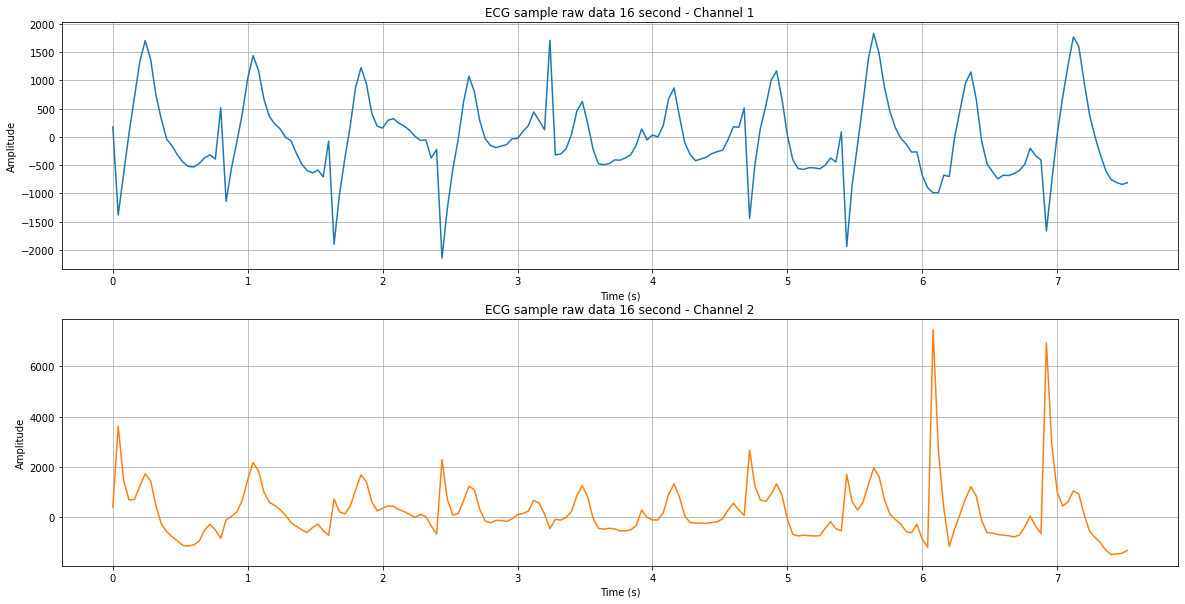

In [11]:
start = (ECG.index[0] + datetime.timedelta(seconds=6)).time()
end = (ECG.index[0] + datetime.timedelta(seconds=12)).time()
print(start, end)

plot_signal(ECG.between_time(start, end), fs, "ECG sample raw data 16 second")

___
## Baseline Wander Removal
### Asymmetric Least Squares Smoothing

In [12]:
from scipy.signal import argrelextrema

In [13]:
from scipy.signal import find_peaks 

In [14]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

In [15]:
def plot_6s_sample(original, als, baseline, label="Plot 6 s sample"):
    times = np.arange(len(original[0]), dtype='float') / fs
    
    plt.figure(figsize=(20, 15))
    
    plt.subplot(3,1,1)
    plt.plot(times, original[0])
    plt.plot(times, baseline[0])
    plt.legend(['original signal - Channel 1', 'baseline'])
    plt.title(label)
    plt.grid(True)
    
    plt.subplot(3,1,2)
    plt.plot(times, original[1])
    plt.plot(times, baseline[1])
    plt.legend(['original signal - Channel 2', 'baseline'])
    plt.title(label)
    plt.grid(True)
    
    plt.subplot(3,1,3)
    plt.plot(times, als[0])
    plt.plot(times, als[1])
    plt.legend(['signal als - Channel 1', 'signal als - Channel 2'])
    plt.grid(True)
    
    plt.show()

In [16]:
def baseline_als(y, lam=10000, p=0.05, n_iter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_iter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

- apply to all sample signal

In [17]:
ECG.index.min(), ECG.index.max()

(Timestamp('2021-08-24 18:40:16.219000'),
 Timestamp('2021-08-24 18:47:32.838000'))

In [18]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta
        
time_interval = [time_result for time_result in perdelta(ECG.index.min(), ECG.index.max(), timedelta(seconds=6))]

In [19]:
ECG_ALS = []
BASELINE_ALS = []
ORI = []
for time_intv in list(zip(time_interval, time_interval[1:])):
    X = ECG.between_time(time_intv[0].time(), time_intv[1].time())
        
    ecg1 = X['ECG1'].values
    ecg2 = X['ECG2'].values

    if len(ecg1) > 0 and len(ecg2) > 0:
        baseline1 = baseline_als(ecg1)
        ALS1 = ecg1 - baseline1
        
        baseline2 = baseline_als(ecg2)
        ALS2 = ecg2 - baseline2

        ORI.append(np.array([ecg1, ecg2]))
        ECG_ALS.append(np.array([ALS1, ALS2]))
        BASELINE_ALS.append(np.array([baseline1, baseline2]))

C:\Users\yunus\AppData\Roaming\Python\Python37\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:198: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


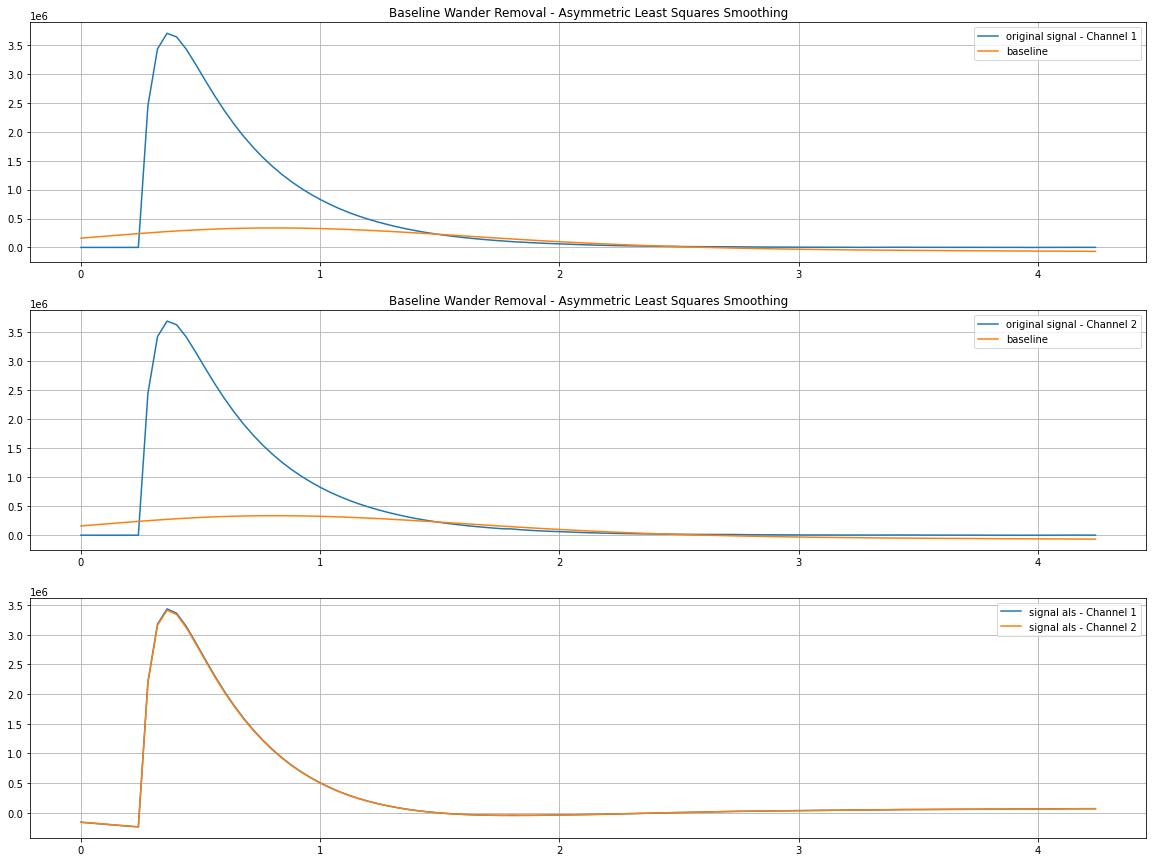

In [20]:
plot_6s_sample(ORI[0], ECG_ALS[0], BASELINE_ALS[0], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing")

___
## Signal Normalization

In [21]:
from sklearn.preprocessing import MaxAbsScaler


In [22]:
scaler = MaxAbsScaler()
ECG_Norm = []

for als in ECG_ALS :
    als1 = np.expand_dims(als[0], 1)
    als2 = np.expand_dims(als[1], 1)
    
    scaler.fit(als1)
    
    als_norm1 = scaler.transform(als1)
    als_norm2 = scaler.transform(als2)
    
    ECG_Norm.append([als_norm1, als_norm2])

C:\Users\yunus\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:978: RuntimeWarning: All-NaN slice encountered
  max_abs = np.nanmax(np.abs(X), axis=0)


In [23]:
def plot_normalized_signal(data, fs, label="ECG sample raw data", y_label="Normalized Value"):
    plt.figure(figsize=(20, 5))
    
    # Calculate time values in seconds
    times = np.arange(data[0].shape[0], dtype='float') / fs

    plt.figure(figsize=(20,10))
    plt.subplot(2,1,1)
    plt.plot(times, data[0], '#1f77b4')
    plt.ylabel(y_label)
    plt.xlabel("Time (s)")
    plt.title(label + " - Channel 2")
    plt.legend(['channel 2'])
    plt.grid(True)
    
    plt.subplot(2,1,2)
    plt.plot(times, data[1], '#ff7f0e')
    plt.ylabel(y_label)
    plt.xlabel("Time (s)")
    plt.title(label + " - Channel 1")
    plt.legend(['channel 1'])
    plt.grid(True)
    plt.show()

<Figure size 1440x360 with 0 Axes>

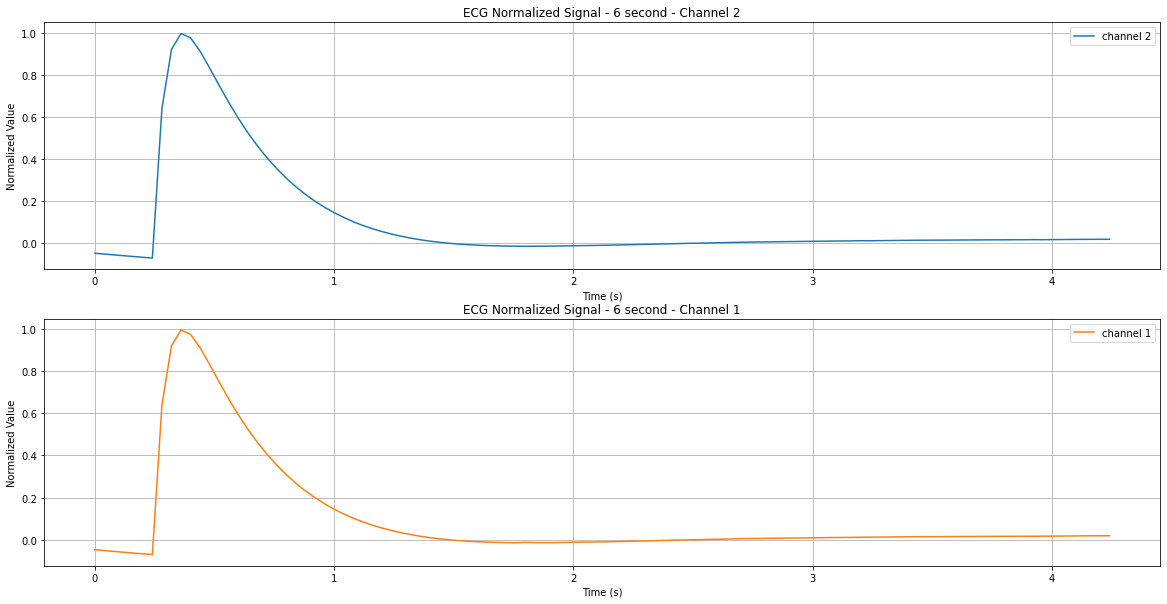

In [24]:
plot_normalized_signal(ECG_Norm[0], fs, "ECG Normalized Signal - 6 second")

____

## Upsampling to 250Hz

In [25]:
from scipy.signal import resample, resample_poly

In [26]:
def upsampling_twice(data):
    # upsampling interpolation
    result = np.zeros(2*len(data)-1)
    result[0::2] = data
    result[1::2] = (data[1:] + data[:-1]) / 2
    return result

In [27]:
new_fs = 250 #Hz

ECG_250Hz = []
for data in ECG_Norm:
    data[0] = upsampling_twice(data[0][:,0]) 
    data[0] = resample_poly(data[0], new_fs, int(new_fs/5))
    
    data[1] = upsampling_twice(data[1][:,0]) 
    data[1] = resample_poly(data[1], new_fs, int(new_fs/5))
    
    ECG_250Hz.append(data)
    

# Save Signal Sequence per-16s Data 

In [28]:
ECG_Norm[0][0].shape

(1065,)

In [29]:
data = []
pad_size = 1500 # 6s x 250hz
for i in range(len(ECG_250Hz)):
    signal_ch = []
    for ch in [0, 1] :
        signal = np.array(ECG_250Hz[i])[ch]
        n = len(signal) if len(signal) <= pad_size else pad_size
        pad = np.zeros(pad_size)
        pad[0:n] = signal[0:n] 
        signal_ch.extend(list(pad))    
    data.append(signal_ch)

In [30]:
ECG = pd.DataFrame(data)

In [31]:
ECG.head()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,-0.046746,-0.051795,-0.053753,-0.053174,-0.051089,-0.048679,-0.046871,-0.046279,-0.046982,-0.048625,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.369232,0.376105,0.339620,0.264507,0.162199,0.048043,-0.062944,-0.156784,-0.224551,-0.262792,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.191141,0.209940,0.214022,0.204910,0.186388,0.163468,0.141235,0.124268,0.116102,0.119316,...,0.088241,0.080001,0.068518,0.052592,0.032024,0.007820,-0.018377,-0.043109,-0.062618,-0.073332
3,0.262592,0.289213,0.297496,0.290602,0.274516,0.256182,0.241174,0.233396,0.233656,0.240208,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.226598,0.259578,0.282255,0.297065,0.308019,0.319230,0.333495,0.351678,0.372556,0.393554,...,1.198681,1.138483,1.081287,1.018958,0.947882,0.869082,0.786390,0.706838,0.636733,0.580464


In [32]:
ECG.to_csv("dataset/AFDB_pasien_%s" % (filename), index=False, header=False)

In [33]:
filename

'Normal 1.csv'